In [34]:
from IPython.display import display
import sys
import spot
from spot.jupyter import display_inline
import buddy
import pdb
spot.setup(show_default='.tvb')

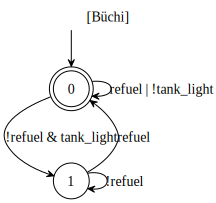

In [41]:
a1 = spot.translate('G(tank_light -> F(refuel))', 'Buchi', 'state-based', 'complete'); a1.show("v")
#a1 = spot.translate('F(refuel)'); a1

In [42]:
print(a1.to_str('hoa'))
a2 = spot.translate('G(!(empty)) & GF(park) & GF(home)')
a2 = spot.translate('G(!(empty))'); a2.show("v")
a2 = spot.translate('F(refuel)')

HOA: v1
States: 2
Start: 0
AP: 2 "tank_light" "refuel"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc complete
properties: deterministic stutter-invariant
--BODY--
State: 0 {0}
[!0 | 1] 0
[0&!1] 1
State: 1
[1] 0
[!1] 1
--END--


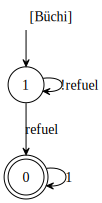

In [37]:
a2.show("v")

In [48]:
print(a2.to_str('hoa'))

HOA: v1
States: 2
Start: 1
AP: 1 "refuel"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc complete
properties: deterministic stutter-invariant terminal
--BODY--
State: 0 {0}
[t] 0
State: 1
[0] 0
[!0] 1
--END--


# Parsing twa_graph object to derive states:

In [49]:
def show_prod(a1, a2, res):
    s1 = a1.num_sets()
    display_inline(a1, a2.show('.tvb+{}'.format(s1)), res)

def prod(left, right):
    # A bdd_dict object associates BDD variables (that are 
    # used in BDDs labeleing the edges) to atomic propositions.
    bdict = left.get_dict()
    # If the two automata do not have the same BDD dict, then
    # we cannot easily detect compatible transitions.
    if right.get_dict() != bdict:
        raise RuntimeError("automata should share their dictionary")
    result = spot.make_twa_graph(bdict)
    # This will be our state dictionary
    sdict = {}
    # The list of output states for which we have not yet
    # computed the successors.  Items on this list are triplets
    # of the form (ls, rs, p) where ls,rs are the state number in
    # the left and right automata, and p is the state number if
    # the output automaton.
    todo = []
    # Transform a pair of state number (ls, rs) into a state number in
    # the output automaton, creating a new state if needed.  Whenever
    # a new state is created, we can add it to todo.
    def dst(ls, rs):
        pair = (ls, rs)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state()
            sdict[pair] = p
            todo.append((ls, rs, p))
        return p
    
    # Setup the initial state.  It always exists.
    result.set_init_state(dst(left.get_init_state_number(), 
                              right.get_init_state_number()))
    # pdb.set_trace()
    # Build all states and edges in the product
    while todo:
        print(todo)
        lt_num = 0
        rt_num = 0
        lsrc, rsrc, osrc = todo.pop()
        print("----------------------------------")
        print(f"new edge in todo: ({lsrc}, {rsrc}, {osrc})")
        
        for lt in left.out(lsrc):
            lt_num += 1
            for rt in right.out(rsrc):
                rt_num += 1
                cond = lt.cond & rt.cond
                print(f"left cond: {lt.cond}")
                print(f"right cond: {rt.cond}")
                print(f"cond: {cond}")
                print("\n")
#                 print(f"buddy false: {buddy.bddfalse}")
#                 print(f"buddy true: {buddy.bddtrue}")
#                 print("Check if cond is the constant true bdd:")
                buddy.bdd_printdot(cond)
                if cond != buddy.bddfalse:
                    print(lt.dst)
                    print(rt.dst)
                    result.new_edge(osrc, dst(lt.dst, rt.dst), cond)
        print(f"No. of outgoing edges in left automata state {lt_num}")
        print(f"No. of outgoing edges in right automata state {rt_num}")

    return result

p1 = prod(a1, a2)
print(f"buddy false: {buddy.bddfalse}")
print(f"buddy true: {buddy.bddtrue}")

[(0, 1, 0)]
----------------------------------
new edge in todo: (0, 1, 0)
left cond: bdd(id=57)
right cond: bdd(id=6)
cond: bdd(id=6)


0
0
left cond: bdd(id=57)
right cond: bdd(id=7)
cond: bdd(id=52)


0
1
left cond: bdd(id=12)
right cond: bdd(id=6)
cond: bdd(id=0)


left cond: bdd(id=12)
right cond: bdd(id=7)
cond: bdd(id=12)


1
1
No. of outgoing edges in left automata state 2
No. of outgoing edges in right automata state 4
[(0, 0, 1), (1, 1, 2)]
----------------------------------
new edge in todo: (1, 1, 2)
left cond: bdd(id=6)
right cond: bdd(id=6)
cond: bdd(id=6)


0
0
left cond: bdd(id=6)
right cond: bdd(id=7)
cond: bdd(id=0)


left cond: bdd(id=7)
right cond: bdd(id=6)
cond: bdd(id=0)


left cond: bdd(id=7)
right cond: bdd(id=7)
cond: bdd(id=7)


1
1
No. of outgoing edges in left automata state 2
No. of outgoing edges in right automata state 4
[(0, 0, 1)]
----------------------------------
new edge in todo: (0, 0, 1)
left cond: bdd(id=57)
right cond: bdd(id=1)
cond: bdd(id=57)

In [50]:
# Defining asynchronous product:
def async_prod(left, right):
    bdict = left.get_dict()
    # If the two automata do not have the same BDD dict, then
    # we cannot easily detect compatible transitions.
    if right.get_dict() != bdict:
        raise RuntimeError("automata should share their dictionary")
    result = spot.make_twa_graph(bdict)
    result.copy_ap_of(left)
    result.copy_ap_of(right)
    # The list of output states for which we have not yet
    # computed the successors.  Items on this list are triplets
    # of the form (ls, rs, p) where ls,rs are the state number in
    # the left and right automata, and p is the state number if
    # the output automaton.
    todo = []
    sdict = {}
    pairs = []   # our array of state pairs
    # Transform a pair of state number (ls, rs) into a state number in
    # the output automaton, creating a new state if needed.  Whenever
    # a new state is created, we can add it to todo.
    def dst(ls, rs):
        pair = (ls, rs)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state()
            sdict[pair] = p
            pairs.append(pair)
            todo.append((ls, rs, p))
        return p
    
    # Setup the initial state.  It always exists.
    result.set_init_state(dst(left.get_init_state_number(), 
                              right.get_init_state_number()))
    
    # The acceptance sets of the right automaton will be shifted by this amount
    shift = left.num_sets()
    # pdb.set_trace()
    # result.set_acceptance(shift + right.num_sets(), left.get_acceptance() | (right.get_acceptance() << shift))
    result.set_acceptance(shift + right.num_sets(),
                          left.get_acceptance() | (right.get_acceptance() << shift)) # Not sure if the and here means both acceptances.

    # Build all states and edges in the product
    while todo:
        print(todo)
        lsrc, rsrc, osrc = todo.pop()
        print("----------------------------------")
        print(f"new edge in todo: ({lsrc}, {rsrc}, {osrc})")
        
        for lt in left.out(lsrc):
            if lt.cond != buddy.bddfalse:
                result.new_edge(osrc, dst(lt.dst, rsrc), lt.cond, lt.acc)
                
        for rt in right.out(rsrc):
            if rt.cond != buddy.bddfalse:
                result.new_edge(osrc, dst(lsrc, rt.dst), rt.cond, rt.acc << shift)
                # membership of this transitions to the new acceptance sets
        
        # Remember the origin of our states
        result.set_product_states(pairs)
        
        # Loop over all the properties we want to preserve if they hold in both automata
        # This ensures that the product of NBAs is an NBA
        for p in ('prop_universal', 'prop_complete', 'prop_weak', 'prop_inherently_weak', 
                  'prop_terminal', 'prop_stutter_invariant', 'prop_state_acc'):
            if getattr(left, p)() and getattr(right, p)():
                getattr(result, p)(True)
    return result, sdict

[(0, 1, 0)]
----------------------------------
new edge in todo: (0, 1, 0)
[(1, 1, 1), (0, 0, 2)]
----------------------------------
new edge in todo: (0, 0, 2)
[(1, 1, 1), (1, 0, 3)]
----------------------------------
new edge in todo: (1, 0, 3)
[(1, 1, 1)]
----------------------------------
new edge in todo: (1, 1, 1)


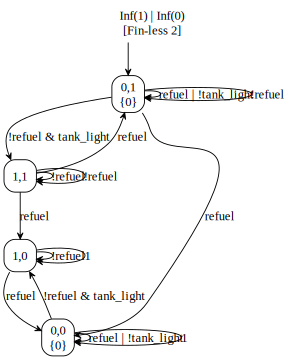

In [51]:
p2, states = async_prod(a1,a2)
# p2 = spot.product(a1,a2)
p2.show("v")
# To-Do: Plot the automata states differently based on which automata is responsible for which action.
# Propositions happen at different player states. Take into account this difference when constructing virtual product automata
# Tp = S * T, Bpi = B1 * B2 --> G = Tp o Bpi
# (??) Tsys = S o B1, Ttest = T o B2 ---> G = Tsys * Ttest; multi-agent LTL examples would shed light on this.

In [52]:
print(a1.ap())
print(a2.ap())
print(p2.ap())
states

(spot.formula("tank_light"), spot.formula("refuel"))
(spot.formula("refuel"),)
(spot.formula("tank_light"), spot.formula("refuel"))


{(0, 1): 0, (1, 1): 1, (0, 0): 2, (1, 0): 3}

In [53]:
p2.get_acceptance()
print(p2.to_str('hoa'))

RuntimeError: print_hoa(): automaton is not universal but prop_universal()==true

In [30]:
def product3(left, right):
    # the twa_graph.is_existential() method returns a Boolean, not a spot.trival
    if not (left.is_existential() and right.is_existential()):
        raise RuntimeError("alternating automata are not supported")
    bdict = left.get_dict()
    if right.get_dict() != bdict:
        raise RuntimeError("automata should share their dictionary")
        
    result = spot.make_twa_graph(bdict)
    result.copy_ap_of(left)
    result.copy_ap_of(right)
    
    pairs = []   # our array of state pairs
    sdict = {}
    todo = []
    def dst(ls, rs):
        pair = (ls, rs)
        p = sdict.get(pair)
        if p is None:
            p = result.new_state()
            sdict[pair] = p
            todo.append((ls, rs, p))
            pairs.append((ls, rs)) # name each state
        return p
    
    result.set_init_state(dst(left.get_init_state_number(), 
                              right.get_init_state_number()))

    shift = left.num_sets()
    result.set_acceptance(shift + right.num_sets(),
                          left.get_acceptance() & (right.get_acceptance() << shift))
    
    while todo:
        lsrc, rsrc, osrc = todo.pop()
        for lt in left.out(lsrc):
            for rt in right.out(rsrc):
                cond = lt.cond & rt.cond
                if cond != buddy.bddfalse:
                    acc = lt.acc | (rt.acc << shift)
                    result.new_edge(osrc, dst(lt.dst, rt.dst), cond, acc)

    # Remember the origin of our states
    result.set_product_states(pairs)
    
    # Loop over all the properties we want to preserve if they hold in both automata
    for p in ('prop_universal', 'prop_complete', 'prop_weak', 'prop_inherently_weak', 
              'prop_terminal', 'prop_stutter_invariant', 'prop_state_acc'):
        if getattr(left, p)() and getattr(right, p)():
            getattr(result, p)(True)
    return result

def show_prod(a1, a2, res):
    s1 = a1.num_sets()
    display_inline(a1, a2.show('.tvb+{}'.format(s1)), res)

prod = product3(a1, a2)
show_prod(a1, a2, prod)

In [31]:
show_prod(a1, a2, p2)